In [ ]:
pip install nlopt

     |████████████████████████████████| 450kB 8.8MB/s 


### Importing Necessary Libraries

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import autograd
import autograd.core
import autograd.extend
import autograd.numpy as anp
import functools
import numpy as np
import scipy
import scipy.ndimage
import scipy.sparse
import scipy.sparse.linalg
import nlopt
import matplotlib.pyplot as plt

### Caching Utilities

In [ ]:
class _WrappedArray:

  def __init__(self, value):
    self.value = value

  def __eq__(self, other):
    return np.array_equal(self.value, other.value)

  def __hash__(self):
    
    return hash(repr(self.value.ravel()))


def ndarray_safe_lru_cache(maxsize=128):
  """An ndarray compatible version of functools.lru_cache."""
  def decorator(func):  # pylint: disable=missing-docstring
    @functools.lru_cache(maxsize)
    def cached_func(*args, **kwargs):
      args = tuple(a.value if isinstance(a, _WrappedArray) else a for a in args)
      kwargs = {k: v.value if isinstance(v, _WrappedArray) else v
                for k, v in kwargs.items()}
      return func(*args, **kwargs)

    @functools.wraps(func)
    def wrapper(*args, **kwargs):  # pylint: disable=missing-docstring
      args = tuple(_WrappedArray(a) if isinstance(a, np.ndarray) else a
                   for a in args)
      kwargs = {k: _WrappedArray(v) if isinstance(v, np.ndarray) else v
                for k, v in kwargs.items()}
      return cached_func(*args, **kwargs)

    return wrapper
  return decorator


### Autograd Utilities

In [ ]:
def _cone_filter_matrix(nelx, nely, radius, mask):
  x, y = np.meshgrid(np.arange(nelx), np.arange(nely), indexing='ij')

  rows = []
  cols = []
  values = []
  r_bound = int(np.ceil(radius))
  for dx in range(-r_bound, r_bound+1):
    for dy in range(-r_bound, r_bound+1):
      weight = np.maximum(0, radius - np.sqrt(dx**2 + dy**2))
      row = x + nelx * y
      column = x + dx + nelx * (y + dy)
      value = np.broadcast_to(weight, x.shape)

      # exclude cells beyond the boundary
      valid = (
          (mask > 0) &
          ((x+dx) >= 0) &
          ((x+dx) < nelx) &
          ((y+dy) >= 0) &
          ((y+dy) < nely)
      )
      rows.append(row[valid])
      cols.append(column[valid])
      values.append(value[valid])

  data = np.concatenate(values)
  i = np.concatenate(rows)
  j = np.concatenate(cols)
  return scipy.sparse.coo_matrix((data, (i, j)), (nelx * nely,) * 2)


@ndarray_safe_lru_cache()
def normalized_cone_filter_matrix(nx, ny, radius, mask):
  """Calculate a sparse matrix appropriate for applying a cone filter."""
  raw_filters = _cone_filter_matrix(nx, ny, radius, mask).tocsr()
  weights = 1 / raw_filters.sum(axis=0).squeeze()
  diag_weights = scipy.sparse.spdiags(weights, 0, nx*ny, nx*ny)
  return (diag_weights @ raw_filters).tocsr()


@autograd.extend.primitive
def cone_filter(inputs, radius, mask=1, transpose=False):
  """Apply a cone filter of the given radius."""
  inputs = np.asarray(inputs)
  filters = normalized_cone_filter_matrix(
      *inputs.shape, radius=radius, mask=mask)
  if transpose:
    filters = filters.T
  outputs = filters @ inputs.ravel(order='F')
  return outputs.reshape(inputs.shape, order='F')


def _cone_filter_vjp(ans, inputs, radius, mask=1, transpose=False):
  del ans, inputs  # unused
  return lambda g: cone_filter(g, radius, mask, transpose=not transpose)
autograd.extend.defvjp(cone_filter, _cone_filter_vjp)


In [ ]:
@autograd.primitive
def find_root(
    f, x, lower_bound, upper_bound, tolerance=1e-12, max_iterations=64):
  # Implicitly solve f(x,y)=0 for y(x) using binary search.
  # Assumption:  y is a scalar and f(x,y) is monotonic in y.
  for _ in range(max_iterations):
    y = 0.5 * (lower_bound + upper_bound)
    if upper_bound - lower_bound < tolerance:
      break
    if f(x, y) > 0:
      upper_bound = y
    else:
      lower_bound = y
  return y

def grad_find_root(y, f, x, lower_bound, upper_bound, tolerance=None):
  def jvp(grad_y):
    g = lambda x: f(x, y)
    h = lambda y: f(x, y)
    return -autograd.grad(g)(x) / autograd.grad(h)(y) * grad_y
  return jvp

def _grad_undefined(_, *args):
  raise TypeError('gradient undefined for this input argument')


def _zero_grad(_, *args, **kwargs):
  def jvp(grad_ans):
    return 0.0 * grad_ans
  return jvp

autograd.extend.defvjp(
    find_root, _grad_undefined, grad_find_root,
    _zero_grad, _zero_grad, _zero_grad)


In [ ]:
@ndarray_safe_lru_cache(1)
def _get_solver(a_entries, a_indices, size, sym_pos):
  """Get a solver for applying the desired matrix factorization."""
  # A cache size of one is sufficient to avoid re-computing the factorization in
  # the backwawrds pass.
  a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc() 
  
  return scipy.sparse.linalg.splu(a).solve


## Sparse solver
@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
  """Solve a sparse system of linear equations.

  Args:
    a_entries: numpy array with shape (num_zeros,) giving values for non-zero
      matrix entries.
    a_indices: numpy array with shape (2, num_zeros) giving x and y indices for
      non-zero matrix entries.
    b: 1d numpy array specifying the right hand side of the equation.
    sym_pos: is the matrix guaranteed to be positive-definite?

  Returns:
    1d numpy array corresponding to the solution of a*x=b.
  """
  solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
  return solver(b)


def solve_coo_adjoint(a_entries, a_indices, b, sym_pos=False):
  
  if sym_pos:
    return solve_coo(a_entries, a_indices, b, sym_pos)
  else:
    return solve_coo(a_entries, a_indices[::-1], b, sym_pos)


def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
  def jvp(grad_ans):
    lambda_ = solve_coo_adjoint(a_entries, a_indices, grad_ans, sym_pos)
    i, j = a_indices
    return -lambda_[i] * ans[j]
  return jvp


def grad_solve_coo_b(ans, a_entries, a_indices, b, sym_pos=False):
  def jvp(grad_ans):
    return solve_coo_adjoint(a_entries, a_indices, grad_ans, sym_pos)
  return jvp


autograd.extend.defvjp(
    solve_coo, grad_solve_coo_entries, _grad_undefined, grad_solve_coo_b)


In [ ]:
def scatter1d(nonzero_values, nonzero_indices, array_len):
  all_indices = np.arange(array_len, dtype=anp.int64)
  zero_indices = anp.setdiff1d(all_indices, nonzero_indices, assume_unique=True)
  index_map = inverse_permutation(
      anp.concatenate([nonzero_indices, zero_indices]))
  u_values = anp.concatenate([nonzero_values, anp.zeros(len(zero_indices))])
  return u_values[index_map]

In [ ]:
def inverse_permutation(indices):
  inverse_perm = np.zeros(len(indices), dtype=anp.int64)
  inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
  return inverse_perm


### Physics , Topology Utilities


In [ ]:
def physical_density(x, args, volume_contraint=False, cf=True):
  shape = (args['nely'], args['nelx'])
  assert x.shape == shape or x.ndim == 1
  x = x.reshape(shape)
  if volume_contraint:
    mask = anp.broadcast_to(args['mask'], x.shape) > 0
    x_designed = sigmoid_with_constrained_mean(x[mask], args['volfrac'])
    x_flat = scatter1d(
        x_designed, anp.flatnonzero(mask), x.size)
    x = x_flat.reshape(x.shape)
  else:
    x = x * args['mask']
  if cf:
    x = cone_filter(x, args['filter_width'], args['mask'])
  return x

def mean_density(x, args, volume_contraint=False, cf=True):
  
  auxil = physical_density(x, args, volume_contraint, cf=True)
  return (auxil.mean()
          / np.mean(args['mask']))

In [ ]:
def get_stiffness_matrix():  
  # Element stiffness matrix
  g = anp.array([2/3 , -1/6 , -1/3, -1/6])
  return anp.array([
                   [g[0] , g[1], g[2], g[3]],
                   [g[3] , g[0], g[1], g[2]],
                   [g[2] , g[3], g[0], g[1]],
                   [g[1] , g[2], g[3], g[0]]
                   ])

In [ ]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
  index_map = inverse_permutation(
      anp.concatenate([freedofs, fixdofs]))
  keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
  i = index_map[k_ylist][keep]
  j = index_map[k_xlist][keep]
  return index_map, keep, anp.stack([i, j])


def displace(x_phys, ke, forces, freedofs, fixdofs, *,
             penal=3, e_min=0.001, e_0=1):                  
  # Displaces the load x using finite element techniques. The spsolve here
  # occupies the majority of this entire simulation's runtime.
  stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
  k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

  index_map, keep, indices = _get_dof_indices(
      freedofs, fixdofs, k_ylist, k_xlist
  )
  u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs],
                                     sym_pos=True)
  
  u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
  
  return u_values[index_map]


def get_k(stiffness, ke):
  # Constructs a sparse stiffness matrix, k, for use in the displace function.
  nely, nelx = stiffness.shape

  # get position of the nodes of each element in the stiffness matrix
  ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
  ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

  n1 = (nely+1)*(elx+0) + (ely+0)
  n2 = (nely+1)*(elx+1) + (ely+0)
  edof = anp.array([n1, n2, n2+1, n1+1]) 
  edof = edof.T[0]

  x_list = anp.repeat(edof, 4)  # flat list pointer of each node in an element
  y_list = anp.tile(edof, 4).flatten()  # flat list pointer of each node in elem

  # make the stiffness matrix
  kd = stiffness.T.reshape(nelx*nely, 1, 1)   
  value_list = (kd * anp.tile(ke, kd.shape)).flatten()
  return value_list, y_list, x_list


def young_modulus(x, e_0, e_min, p=3):
  return e_min + x ** p * (e_0 - e_min)


def compliance(x_phys, u, ke, *, penal=3, e_min=0.001, e_0=1):
  # index map
  nely, nelx = x_phys.shape
  ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords

  # nodes
  n1 = (nely+1)*(elx+0) + (ely+0)
  n2 = (nely+1)*(elx+1) + (ely+0)
  all_ixs = anp.array([n1, n2, n2+1, n1+1]) 
  # select from u matrix
  u_selected = u[all_ixs]
  # compute x^penal * U.T @ ke @ U in a vectorized way
  ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)
  ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
  C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
  return anp.sum(C)

In [ ]:
def sigmoid(x):
  return anp.tanh(0.5*x)*.5 + 0.5


def logit(p):
  p = anp.clip(p, 0, 1)
  return anp.log(p) - anp.log1p(-p)


def sigmoid_with_constrained_mean(x, average):
  f = lambda x, y: sigmoid(x + y).mean() - average
  lower_bound = logit(average) - anp.max(x)
  upper_bound = logit(average) - anp.min(x)
  b = find_root(f, x, lower_bound, upper_bound)
  return sigmoid(x + b)


def calculate_forces(x_phys, args):
  applied_force = args['forces']

  return applied_force


def objective(x, ke, args, volume_contraint=False, cfo=True):
  """Objective function (compliance) for topology optimization."""
  kwargs = dict(penal=args['penal'], e_min=args['young_min'], e_0=args['young'])
  x_phys = physical_density(x, args, volume_contraint=volume_contraint,
                            cf=cfo)
  forces = calculate_forces(x_phys, args)
  u = displace(
      x_phys, ke, forces, args['freedofs'], args['fixdofs'], **kwargs)
  c = compliance(x_phys, u, ke, **kwargs)
  return c


### Models

In [ ]:
layers = tf.keras.layers

In [ ]:
def batched_topo_loss(params, envs):
  losses = [env.objective(params[i], volume_contraint=True)
            for i, env in enumerate(envs)]
  return anp.stack(losses)

In [ ]:
def convert_autograd_to_tensorflow(func):
  @tf.custom_gradient
  def wrapper(x):
    vjp, ans = autograd.core.make_vjp(func, x.numpy())
    return ans, vjp
  return wrapper

In [ ]:
def set_random_seed(seed):
  if seed is not None:
    anp.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
def global_normalization(inputs, epsilon=1e-6):
  mean, variance = tf.nn.moments(inputs, axes=list(range(len(inputs.shape))))
  net = inputs
  net -= mean
  net *= tf.math.rsqrt(variance + epsilon)
  return net

In [ ]:
class Model(tf.keras.Model):

  def __init__(self, seed=None, args=None):
    super().__init__()
    set_random_seed(seed)
    self.seed = seed
    self.env = Environment(args)

  def loss(self, logits):
    # for our neural network, we use float32, but we use float64 for the physics
    # to avoid any chance of overflow.
    # add 0.0 to work-around bug in grad of tf.cast on NumPy arrays
    logits = 0.0 + tf.cast(logits, tf.float64)
    f = lambda x: batched_topo_loss(x, [self.env])
    losses = convert_autograd_to_tensorflow(f)(logits)
    return tf.reduce_mean(losses)

In [ ]:
def UpSampling2D(factor):
  return layers.UpSampling2D((factor, factor), interpolation='bilinear')


def Conv2D(filters, kernel_size, **kwargs):
  return layers.Conv2D(filters, kernel_size, padding='same', **kwargs)


class AddOffset(layers.Layer):

  def __init__(self, scale=1):
    super().__init__()
    self.scale = scale

  def build(self, input_shape):
    self.bias = self.add_weight(
        shape=input_shape, initializer='zeros', trainable=True, name='bias')

  def call(self, inputs):
    return inputs + self.scale * self.bias

In [ ]:
class PixelModel(Model):

  def __init__(self, seed=None, args=None):
    super().__init__(seed, args)
    shape = (1, self.env.args['nely'], self.env.args['nelx'])
    z_init = np.broadcast_to(args['volfrac'] * args['mask'], shape)
    self.z = tf.Variable(z_init, trainable=True)

  def call(self, inputs=None):
    return self.z

In [ ]:
class CNNModel(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size=128,
      dense_channels=32,
      resizes=(1, 1, 2, 2, 1),
      conv_filters=(128, 64, 32, 16, 1),
      offset_scale=10,
      kernel_size=(5, 5),
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation=tf.nn.tanh,
      conv_initializer=tf.initializers.VarianceScaling,
      normalization=global_normalization,
  ):
    super().__init__(seed, args)

    if len(resizes) != len(conv_filters):
      raise ValueError('resizes and filters must be same size')

    activation = layers.Activation(activation)

    total_resize = int(anp.prod(resizes))
    h = self.env.args['nely'] // total_resize
    w = self.env.args['nelx'] // total_resize

    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)

    for resize, filters in zip(resizes, conv_filters):
      net = activation(net)
      net = UpSampling2D(resize)(net)
      net = normalization(net)
      net = Conv2D(
          filters, kernel_size, kernel_initializer=conv_initializer)(net)
      if offset_scale != 0:
        net = AddOffset(offset_scale)(net)

    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

### Problems designed 

In [ ]:
from typing import Optional, Union
import dataclasses


@dataclasses.dataclass
class Problem:
  """Description of a topology optimization problem.

  Attributes:
    normals: float64 array of shape (width+1, height+1) where a value of 1
      indicates a "fixed" coordinate, and 0 indicates no heat sink.
    forces: float64 array of shape (width+1, height+1) indicating external
      applied thermal load.
    density: fraction of the design region that should be non-zero.
    mask: scalar or float64 array of shape (height, width) that is multiplied by
      the design mask before and after applying the blurring filters. Values of
      1 indicate regions where the material can be optimized; values of 0 are
      constrained to be empty.
    name: optional name of this problem.
    width: integer width of the domain.
    height: integer height of the domain.
  """
  normals: np.ndarray
  forces: np.ndarray
  density: float
  mask: Union[np.ndarray, float] = 1
  name: Optional[str] = None
  width: int = dataclasses.field(init=False)
  height: int = dataclasses.field(init=False)

  def __post_init__(self):
    self.width = self.normals.shape[0] - 1
    self.height = self.normals.shape[1] - 1

    if self.normals.shape != (self.width + 1, self.height + 1):
      raise ValueError(f'normals has wrong shape: {self.normals.shape}')
    if self.forces.shape != (self.width + 1, self.height + 1, 1):
      raise ValueError(f'forces has wrong shape: {self.forces.shape}')
    if (isinstance(self.mask, np.ndarray)
        and self.mask.shape != (self.height, self.width)):
      raise ValueError(f'mask has wrong shape: {self.mask.shape}')



def Problem1(width=40, height=40, density=0.4):
  normals = np.zeros((width + 1, height + 1))
  normals[0, :] = 1
  normals[-1, :] = 1
  normals[: , 0] = 1
  normals[: , -1] = 1
  
  forces = np.ones((width + 1, height + 1, 1))

  return Problem(normals, forces, density)

def Problem2(width = 40 , height=40 , density=0.4):
  normals = np.zeros((width + 1, height + 1))
  normals[0 , (height+1)//2] = 1

  forces = np.ones((width + 1, height + 1, 1))

  return Problem(normals, forces, density)

def Problem3(width = 60 , height=40 , density=0.4):
  normals = np.zeros((width+1, height+1))
  normals[(width+1)//2,(height+1)//2]=1 

  forces = np.ones((width + 1, height + 1, 1))

  return Problem(normals, forces, density)

def Problem4(width=80, height=80, density=0.4):
  normals = np.zeros((width+1, height+1))
  normals[0, :] = 1
  normals[-1, :] = 1
  normals[: , 0] = 1
  normals[: , -1] = 1

  forces = np.zeros((width+1, height+1,1))
  forces[(width+1)//2 ,1, :]=1
  forces[(width+1)//2, -2, :]=1

  return Problem(normals, forces, density)

def Problem5(width=80 , height=80, density=0.4):
  normals = np.zeros((width+1, height+1))
  normals[0,0] = 1 

  forces = np.zeros((width+1, height+1, 1))
  forces[(width+1)//2, (height+1)//2, :] = 1

  return Problem(normals, forces, density)

def Problem6(width=80, height=80, density=0.5):
  normals = np.zeros((width+1, height+1))
  normals[(width+1)//2, 1]=1
  
  forces = np.zeros((width+1, height+1, 1))
  forces[(width+1)//2, -2,:]=1

  return Problem(normals, forces, density)


### Class like environment for problems, for better usability

In [ ]:
def specified_task(problem):
  """Given a problem, return parameters for running a topology optimization."""
  fixdofs = anp.flatnonzero(problem.normals.ravel())
  alldofs = anp.arange((problem.width + 1) * (problem.height + 1))
  freedofs = anp.sort(list(set(alldofs) - set(fixdofs)))

  params = {
      # material properties
      'young': 1,  ## represents thermal Young's modulus , known as Conductivity
      'young_min': 0.001,  ## represent minimum Conductivity
      # constraints
      'volfrac': problem.density,
      'xmin': 0.001,
      'xmax': 1.0,
      # input parameters
      'nelx': problem.width,
      'nely': problem.height,
      'mask': problem.mask,
      'freedofs': freedofs,
      'fixdofs': fixdofs,
      'forces': problem.forces.ravel(),
      'penal': 3.0,
      'filter_width': 1.5,
  }
  return params

In [ ]:
class Environment:

  def __init__(self, args):
    self.args = args
    self.ke = get_stiffness_matrix()  ## Thermal stiffness matrix, called element Conductivity matrix

  def reshape(self, params):
    return params.reshape(self.args['nely'], self.args['nelx'])

  def render(self, params, volume_contraint=True):
    return physical_density(
        self.reshape(params), self.args, volume_contraint=volume_contraint,
    )

  def objective(self, params, volume_contraint=False):
    return objective(
        self.reshape(params), self.ke, self.args,
        volume_contraint=volume_contraint,
    )

  def constraint(self, params):
    volume = mean_density(self.reshape(params), self.args)
    return volume - self.args['volfrac']

### Training Utilities for CNN-LBFGS, CNN-Ranger, MMA

In [ ]:
import scipy.optimize
import xarray
from absl import logging

In [ ]:
def _set_variables(variables, x):
  shapes = [v.shape.as_list() for v in variables]
  values = tf.split(x, [anp.prod(s) for s in shapes])
  for var, value in zip(variables, values):
    var.assign(tf.reshape(tf.cast(value, var.dtype), var.shape))

In [ ]:
def _get_variables(variables):
  return anp.concatenate([
      v.numpy().ravel() if not isinstance(v, anp.ndarray) else v.ravel()
      for v in variables])

In [ ]:
def optimizer_result_dataset(losses, frames, save_intermediate_designs=False):
  best_design = anp.nanargmin(losses)
  logging.info(f'Final loss: {losses[best_design]}')
  if save_intermediate_designs:
    ds = xarray.Dataset({
        'loss': (('step',), losses),
        'design': (('step', 'y', 'x'), frames),
    }, coords={'step': anp.arange(len(losses))})
  else:
    ds = xarray.Dataset({
        'loss': (('step',), losses),
        'design': (('y', 'x'), frames[best_design]),
    }, coords={'step': anp.arange(len(losses))})
  return ds

In [ ]:
def train_lbfgs(
    model, max_iterations, save_intermediate_designs=True, **kwargs):
  model(None)  # build model, if not built

  losses = []
  frames = []

  tvars = model.trainable_variables

  def value_and_grad(x):
    _set_variables(tvars, x)
    with tf.GradientTape() as t:
      t.watch(tvars)
      logits = model(None)
      loss = model.loss(logits)
    grads = t.gradient(loss, tvars)
    frames.append(logits.numpy().copy())
    losses.append(loss.numpy().copy())
    return float(loss.numpy()), _get_variables(grads).astype(anp.float64)

  x0 = _get_variables(tvars).astype(anp.float64)
  # rely upon the step limit instead of error tolerance for finishing.
  _, _, info = scipy.optimize.fmin_l_bfgs_b(
      value_and_grad, x0, maxfun=max_iterations, factr=1, pgtol=1e-14, **kwargs
  )
  logging.info(info)

  designs = [model.env.render(x, volume_contraint=True) for x in frames]
  return optimizer_result_dataset(
      anp.array(losses), anp.array(designs), save_intermediate_designs)


In [ ]:
def method_of_moving_asymptotes(
    model, max_iterations, save_intermediate_designs=True):

  if not isinstance(model, PixelModel):
    raise ValueError('MMA only defined for pixel models')

  env = model.env
  grad = []
  x0 = _get_variables(model.trainable_variables).astype(np.float64)

  def objective(x):
    return env.objective(x, volume_contraint=False)

  def constraint(x):
    return env.constraint(x)

  def wrap_autograd_func(func, losses=None, frames=None):
    def wrapper(x, grad):
      if grad.size > 0:
        value, grad[:] = autograd.value_and_grad(func)(x)
      else:
        value = func(x)
      if losses is not None:
        losses.append(value)
      if frames is not None:
        frames.append(env.reshape(x).copy())
      return value
    return wrapper

  losses = []
  frames = []

  opt = nlopt.opt(nlopt.LD_MMA, x0.size)
  opt.set_lower_bounds(0)
  opt.set_upper_bounds(1.0)
  opt.set_min_objective(wrap_autograd_func(objective, losses, frames))
  opt.add_inequality_constraint(wrap_autograd_func(constraint), 1e-8)
  opt.set_maxeval(max_iterations + 1)
  opt.optimize(x0)

  designs = [env.render(x, volume_contraint=False) for x in frames]
  return optimizer_result_dataset(np.array(losses), np.array(designs),
                                  save_intermediate_designs)

In [ ]:
radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

def train_tf_optimizer(
    model, max_iterations, optimizer=ranger, save_intermediate_designs=True,
):
  loss = 0
  model(None)  # build model, if not built
  tvars = model.trainable_variables

  losses = []
  frames = []
  for i in range(max_iterations + 1):
    with tf.GradientTape() as t:
      t.watch(tvars)
      logits = model(None)
      loss = model.loss(logits)

    losses.append(loss.numpy().item())
    frames.append(logits.numpy())

    if i % (max_iterations // 10) == 0:
      logging.info(f'step {i}, loss {losses[-1]:.2f}')

    if i < max_iterations:
      grads = t.gradient(loss, tvars)
      optimizer.apply_gradients(zip(grads, tvars))

  designs = [model.env.render(x, volume_contraint=True) for x in frames]
  return optimizer_result_dataset(np.array(losses), np.array(designs),
                                  save_intermediate_designs)


train_ranger = functools.partial(
    train_tf_optimizer, optimizer=ranger)

### Plotting utility function

In [ ]:
def all_plot(dsc,dsa, dsm, limit=100):
  fig ,ax = plt.subplots(2,2, figsize=(10,8))

  ax[0,0].imshow(dsc.design[-1] , cmap='Greys')
  ax[0,0].set_title("CNN-LBFGS")

  ax[0,1].imshow(dsa.design[-1], cmap='Greys')
  ax[0,1].set_title("CNN-Ranger")

  ax[1,0].imshow(dsm.design[-1], cmap='Greys')
  ax[1,0].set_title("MMA")

  ax[1,1].plot(dsc.loss.values[limit:], label="CNN-LBFGS")
  ax[1,1].plot(dsa.loss.values[limit:], label="CNN-Ranger")
  ax[1,1].plot(dsm.loss.values[limit:], label="MMA")
  ax[1,1].legend()
  ax[1,1].set(xlabel="Optimization Step", ylabel="Loss")
  

In [ ]:
def all_plot2(dsc, dsm, limit=100):
  fig ,ax = plt.subplots(2,2, figsize=(10,8))

  ax[0,0].imshow(dsc.design[-1] , cmap='Greys')
  ax[0,0].set_title("CNN-LBFGS")

  ax[1,0].imshow(dsm.design[-1], cmap='Greys')
  ax[1,0].set_title("MMA")

  ax[1,1].plot(dsc.loss.values[limit:], label="CNN-LBFGS")
  ax[1,1].plot(dsm.loss.values[limit:], label="MMA")

  ax[1,1].legend()
  ax[1,1].set(xlabel="Optimization Step", ylabel="Loss")

## Training for different problems

### Problem 1 :
   A 40x40 square 2D plate with uniform heating everywhere and all the boundaries act as sink. 
   
   The volume fraction is taken to  be 0.4 

In [ ]:
problem = Problem1(180, 180)
args = specified_task(problem)

#### CNN-LBFGS

In [ ]:
cnn_lbfgs = CNNModel(args=args)

In [ ]:
ds_cnn = train_lbfgs(cnn_lbfgs, 1000)

#### CNN-Ranger

In [ ]:
cnn_ranger = CNNModel(args=args)

In [ ]:
ds_ranger = train_tf_optimizer(cnn_ranger , 1000)

#### MMA

In [ ]:
mma = PixelModel(args = args)

In [ ]:
ds_pmma = method_of_moving_asymptotes(mma , 1000)

#### Visualizing

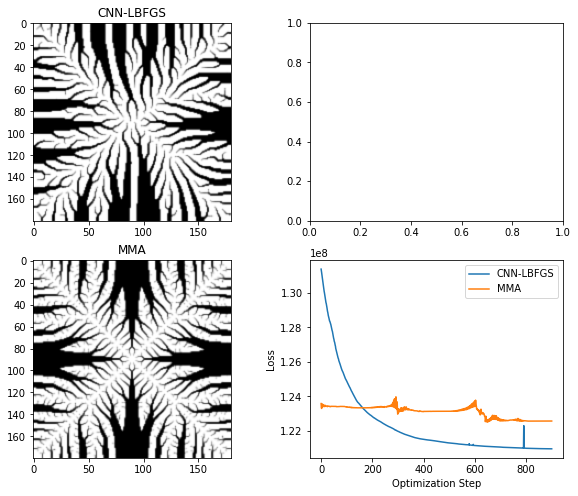

In [ ]:
all_plot2(ds_cnn, ds_pmma)

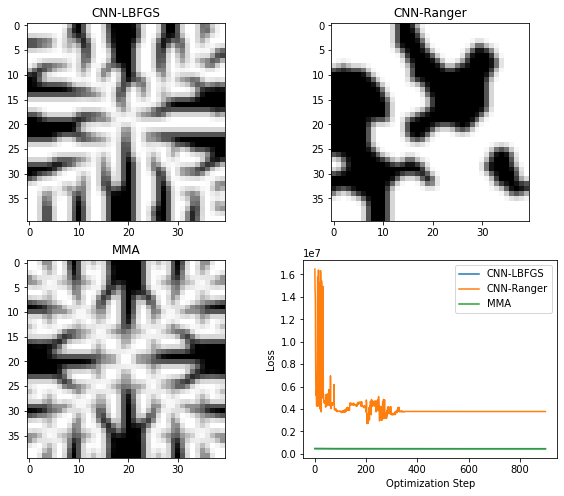

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma)

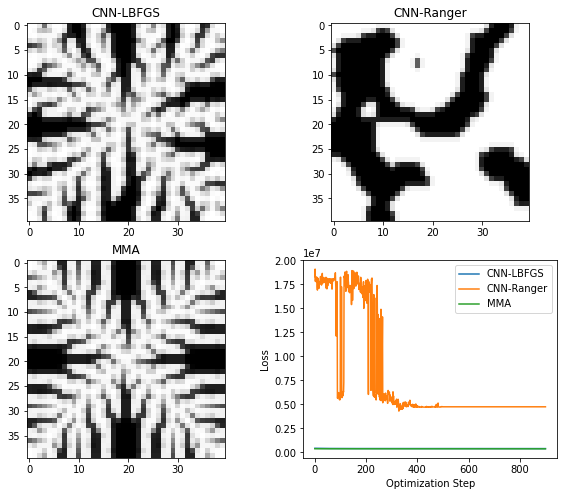

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma)

### Problem 2:
A 40x40 square 2D plate with uniform heating everywhere and sink is located at the centre of left edge.

The volume fraction is 0.4

In [ ]:
problem = Problem2(180, 180)
args = specified_task(problem)

#### CNN-LBFGS

In [ ]:
cnn_lbfgs = CNNModel(args=args)

In [ ]:
ds_cnn = train_lbfgs(cnn_lbfgs, 1000)

#### CNN-Ranger

In [ ]:
cnn_ranger = CNNModel(args=args)

In [ ]:
ds_ranger = train_tf_optimizer(cnn_ranger , 1000)

####MMA

In [ ]:
mma = PixelModel(args = args)

In [ ]:
ds_pmma = method_of_moving_asymptotes(mma , 1000)

#### Visualization

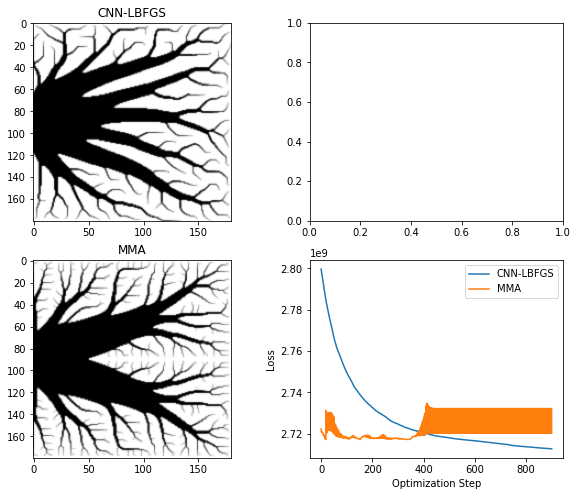

In [ ]:
all_plot2(ds_cnn, ds_pmma)

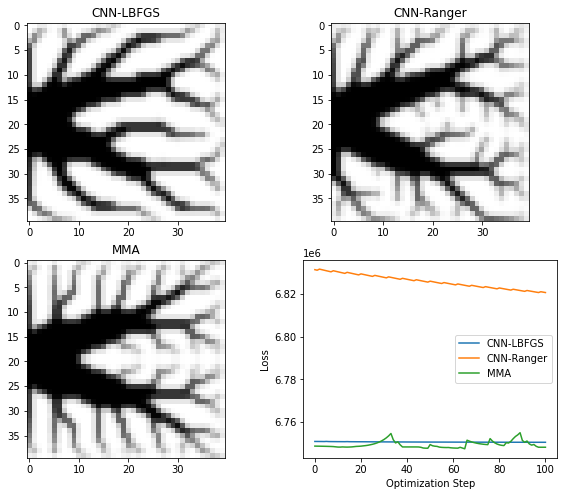

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma, 900)

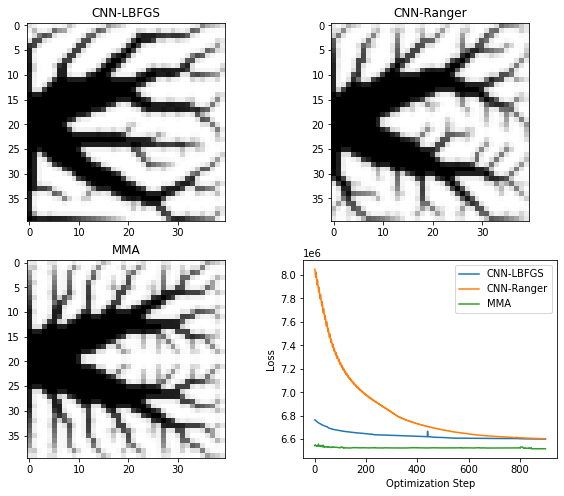

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma)

### Problem 3:
A 40x60 square 2D plate with uniform heating everywhere and sink is located at the centre of the plate.

The volume fraction is 0.4

In [ ]:
problem = Problem3()
args = specified_task(problem)

#### CNN-LBFGS

In [ ]:
cnn_lbfgs = CNNModel(args=args)

In [ ]:
ds_cnn = train_lbfgs(cnn_lbfgs, 1000)

#### CNN-Ranger

In [ ]:
cnn_ranger = CNNModel(args=args)

In [ ]:
ds_ranger = train_tf_optimizer(cnn_ranger , 1000)

#### MMA

In [ ]:
mma = PixelModel(args = args)

In [ ]:
ds_pmma = method_of_moving_asymptotes(mma , 1000)

#### Visualization

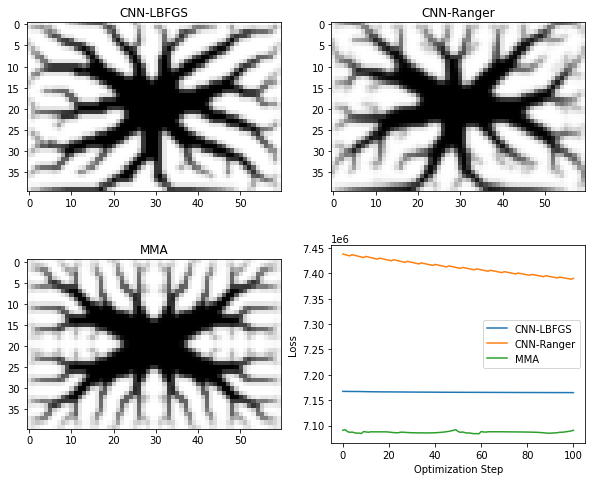

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma,900)

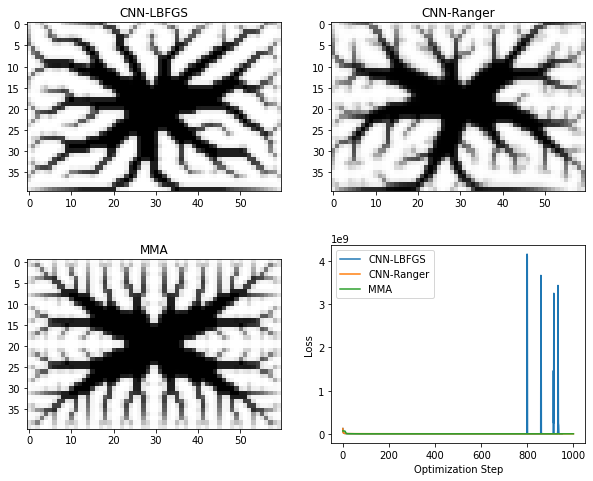

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma, 0)

### Problem 4:
A 80x80 square 2D plate with 2 point heat source  and all the boundaries act as sink.

Volume fraction is 0.4

In [ ]:
problem = Problem4()
args = specified_task(problem)

#### CNN-LBFGS

In [ ]:
cnn_lbfgs = CNNModel(args=args)

In [ ]:
ds_cnn = train_lbfgs(cnn_lbfgs, 1000)

#### CNN-Ranger

In [ ]:
cnn_ranger = CNNModel(args=args)

In [ ]:
ds_ranger = train_tf_optimizer(cnn_ranger , 1000)

#### MMA

In [ ]:
mma = PixelModel(args = args)

In [ ]:
ds_pmma = method_of_moving_asymptotes(mma , 1000)

#### Visualization

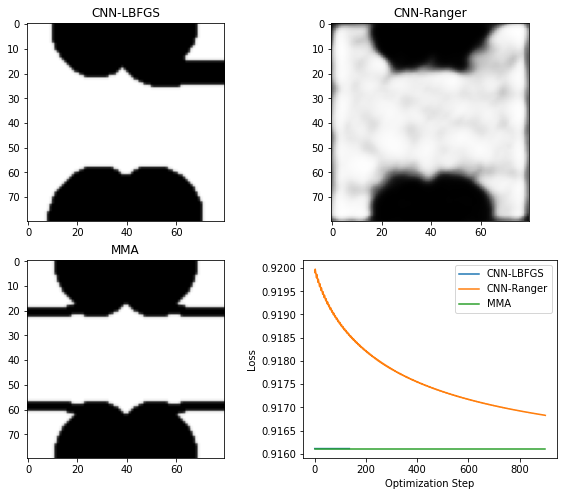

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma)

### Problem 5:
A 80x80 square 2D plate with a point heat source at the centre and sink at the top left corner

Volume fraction is 0.4

In [ ]:
problem = Problem5()
args = specified_task(problem)

#### CNN-LBFGS

In [ ]:
cnn_lbfgs = CNNModel(args=args)

In [ ]:
ds_cnn = train_lbfgs(cnn_lbfgs, 1000)

#### CNN-Ranger

In [ ]:
cnn_ranger = CNNModel(args=args)

In [ ]:
ds_ranger = train_tf_optimizer(cnn_ranger , 1000)

#### MMA

In [ ]:
mma = PixelModel(args = args)

In [ ]:
ds_pmma = method_of_moving_asymptotes(mma , 1000)

#### Visualization

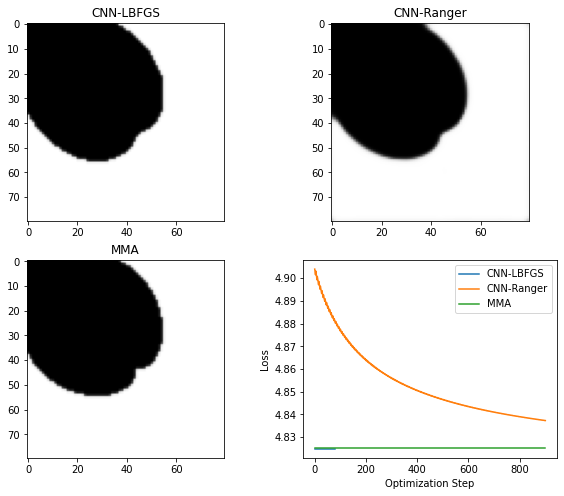

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma)

### Problem 6:
A 80x80 square 2D plate with a point heat source and a point sink inside the boundary of the plate.

Volume fraction is 0.5

In [ ]:
problem = Problem6()
args = specified_task(problem)

#### CNN-LBFGS

In [ ]:
cnn_lbfgs = CNNModel(args=args)

In [ ]:
ds_cnn = train_lbfgs(cnn_lbfgs, 1000)

#### CNN-Ranger

In [ ]:
cnn_ranger = CNNModel(args=args)

In [ ]:
ds_ranger = train_tf_optimizer(cnn_ranger , 1000)

#### MMA

In [ ]:
mma = PixelModel(args = args)

In [ ]:
ds_pmma = method_of_moving_asymptotes(mma , 1000)

#### Visualization

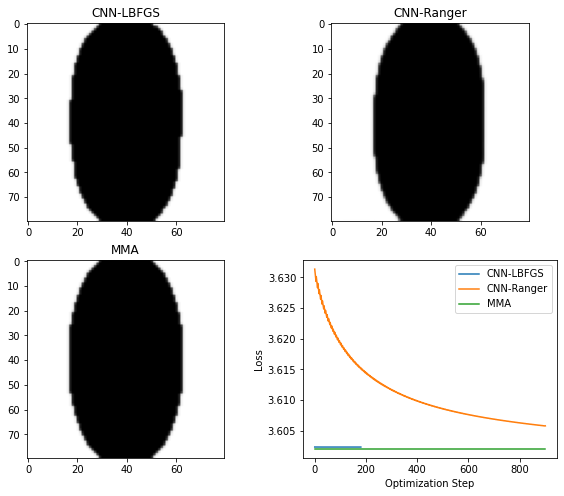

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma)

### Problem 7:

This is similar to Problem 2 but the plate has dimensions 80x80

In [ ]:
problem = Problem2(width=80, height=80)
args = specified_task(problem)

#### CNN-LBFGS

In [ ]:
cnn_lbfgs = CNNModel(args=args)

In [ ]:
ds_cnn = train_lbfgs(cnn_lbfgs, 1000)

#### CNN-Ranger

In [ ]:
cnn_ranger = CNNModel(args=args)

In [ ]:
ds_ranger = train_tf_optimizer(cnn_ranger , 1000)

#### MMA

In [ ]:
mma = PixelModel(args = args)

In [ ]:
ds_pmma = method_of_moving_asymptotes(mma , 1000)

#### Visualization

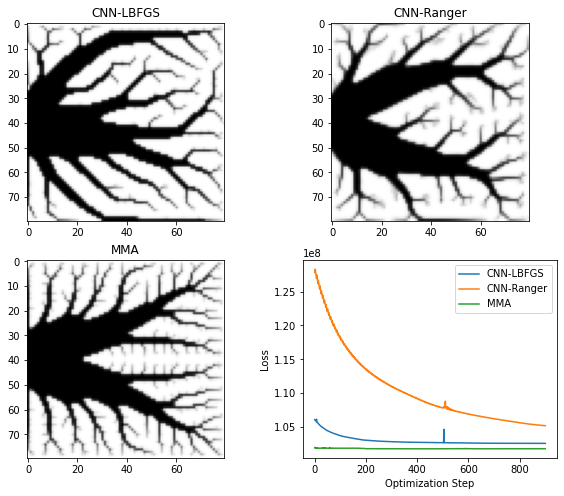

In [ ]:
all_plot(ds_cnn, ds_ranger, ds_pmma)